In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
params = {"ytick.color" : "c",
          "xtick.color" : "c",
          "axes.labelcolor" : "c",
          "axes.edgecolor" : "c",
         "text.color" : "c"}
plt.rcParams.update(params)

import pandas as pd

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN


In [2]:
import random
import pandas as pd
from collections import Counter
from itertools import cycle

from sklearn import datasets, metrics
from sklearn.decomposition import PCA

import spectral
import seaborn as sns 


In [3]:
#wczytanie zdjecia za pomoca bibliteki do zdjec spektralnych
img = spectral.open_image('APEX_OSD_V1_calibr_cube.hdr')
DATA = img.load()
#ENVI is a registered trademark of Exelis, Inc., 
#Opens an image or spectral library with an associated ENVI HDR header file.

In [4]:
#z uwagi na za malo ilosc ramu zajmuje sie gorna polowa podanego zdjecia
data = DATA[:750,:,:]
print(data.shape)
X = data.reshape(-1, data.shape[-1])
X_std = (X - X.mean()) / X.std()
X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))

(750, 1000, 285)


In [6]:
#kod ktory umozliwi grupowanie calego zdjecia
#data = DATA[:,:,:]
#data.shape
#X = data.reshape(-1, data.shape[-1])
#X_std = (X - X.mean()) / X.std()
#X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))

In [5]:
#definicje kolejnych wskaznikow poprawnosci
def dist_matrix(X, r):
    res = (np.sum(X ** 2, axis=1)[:,np.newaxis] - 2 * np.dot(X,r.T) +
                np.sum(r ** 2, axis=1))
    return np.sqrt(np.round(res,10))

#worst case indicator
def dunn_index(X, labels):#, centroid): #wlasna implementacja
    k = np.unique(labels).size
    #z definicji minimalna odleglosci miedzy clustrami
    intercluster = min((np.min(dist_matrix(X[labels == i], X[labels == j]))
                         for i in range(k) for j in range(i + 1, k)))
    intracluster = max((np.max(dist_matrix(X[labels == i], X[labels == i])) for i in range(k)))
    return intercluster / intracluster


def davies_bouldin_index(X, labels, C):
    k = np.unique(labels).size
    #Si
    dist = [np.sqrt(np.sum(dist_matrix(X[labels == i], np.array([C[i]])) ** 2) / np.sum(labels == i))
                 for i in range(k)]
    #Mij
    centroids_dist = dist_matrix(C, C)
    #DB - sum max (Si+Sj)/Mij / N
    res = np.sum([max(((dist[i] + dist[j]) / centroids_dist[i][j] for j in range(k) if i != j))
                  for i in range(k)]) / k
    return res

In [6]:
def show_results(model):
    #model.labels - lables kazdego punktu
    image = model.labels_.reshape(data.shape[0], data.shape[1])#tworzymy macierz zdjecia
    labels_no = np.unique(model.labels_).size#ile klastrow
    res = [(labels_no + 3 - 1) // 3,3]#wymiary pod subploty
    fig, axes = plt.subplots(res[0], res[1])
    fig.set_size_inches(15, res[0] * 5)
    for i in range(labels_no):#dla kazdego klastra
        subplt = np.zeros(image.shape)
        subplt[image == i] = 1#wszystkie nalezace do klastra
        row, col = i // res[1], i % res[1]#pozycja na siatce
        if res[0] == 1:#dla tabeli wysokosci 1
            axes[col].imshow(subplt, cmap='ocean')
            axes[col].set_title(f'cluster: {i}')
        else:
            axes[row][col].imshow(subplt, cmap='ocean')
            axes[row][col].set_title(f'cluster: {i}')
      #'''  
    plt.figure(figsize=(15, 10))
    plt.title('Pełne zdjęcie')
    plt.imshow(image, cmap='ocean')

/home/oskar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


DB_index: 1.0582892453594146
CPU times: user 32 s, sys: 1.67 s, total: 33.7 s
Wall time: 9.82 s


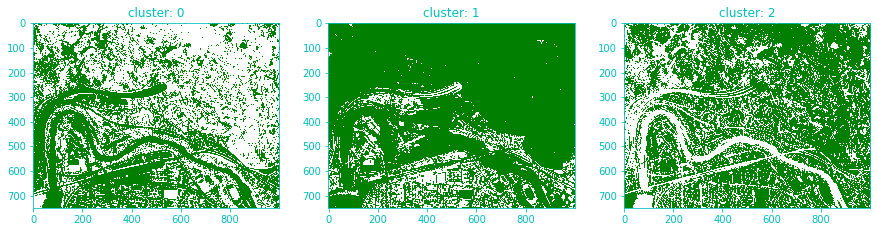

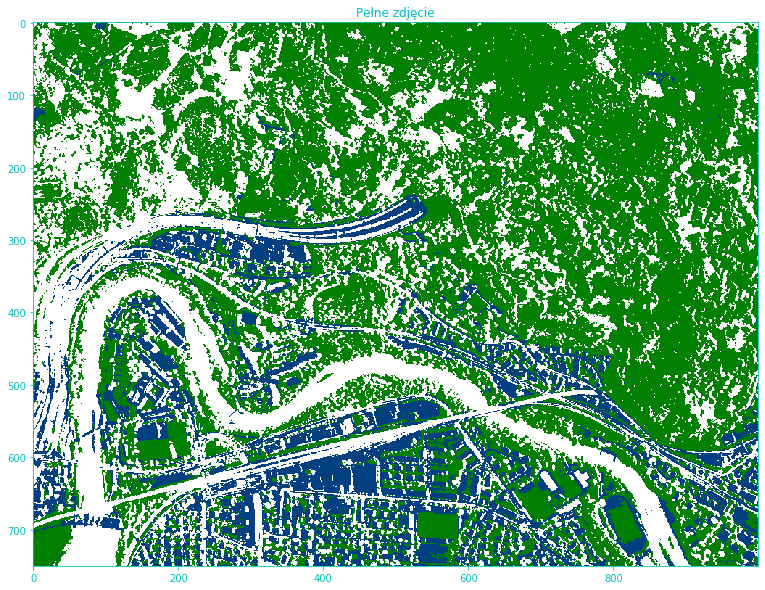

In [15]:
%%time
#minibatch Kmeans ze wzgledu na szybkosc dzialania
model = MiniBatchKMeans(n_clusters=3, n_init=10)
model.fit(X)
show_results(model)
print(f'DB_index: {davies_bouldin_index(X, model.labels_, model.cluster_centers_)}')

#nie jestem w stanie w rozsadnym czasie liczyc pozostalych wskaznikow
#print(f'dunn_index: {dunn_index(X, model.labels_)}')
#print(f'silhouette index: {metrics.silhouette_score(X, model.labels_)}')

Davies Bouldin index: 0.9874658118703311
CPU times: user 21.6 s, sys: 1.31 s, total: 22.9 s
Wall time: 6.32 s


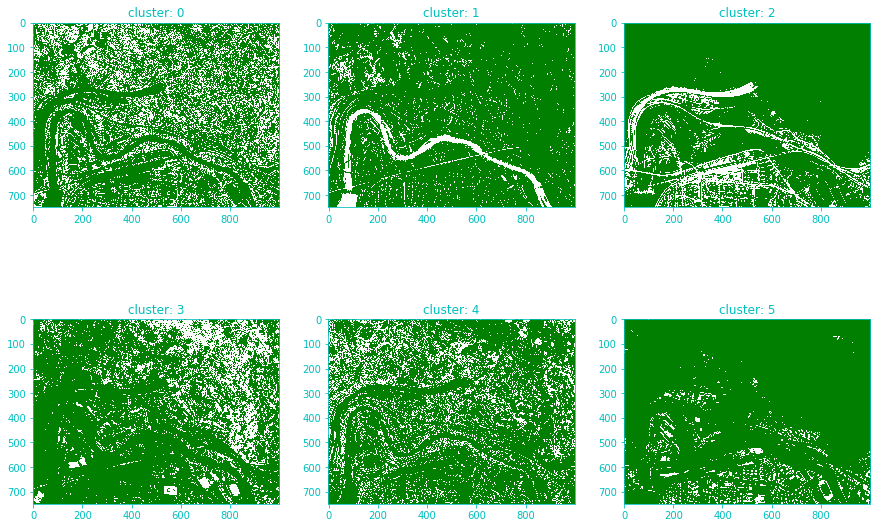

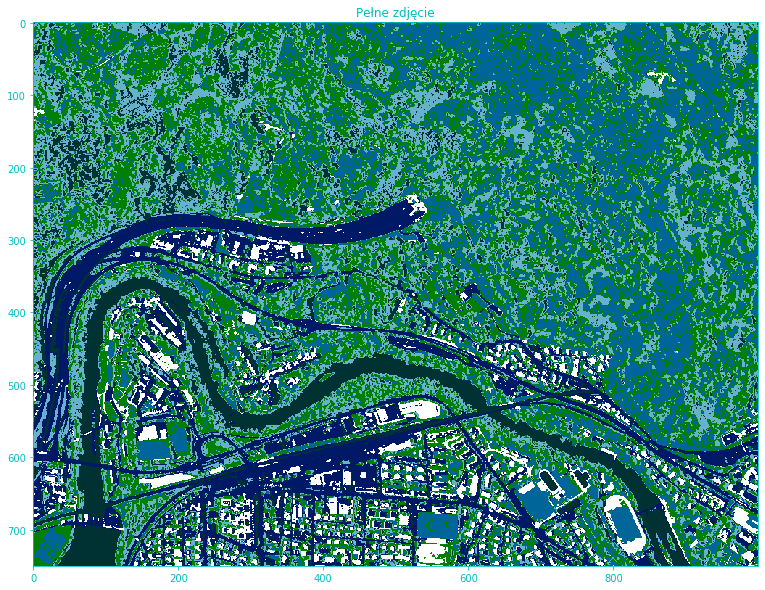

In [71]:
%%time
model = MiniBatchKMeans(n_clusters=6, n_init=10)
model.fit(X)
show_results(model)
print(f'Davies Bouldin index: {davies_bouldin_index(X, model.labels_, model.cluster_centers_)}')

Davies Bouldin index: 1.2445995316105753
CPU times: user 24.2 s, sys: 1.32 s, total: 25.5 s
Wall time: 6.98 s


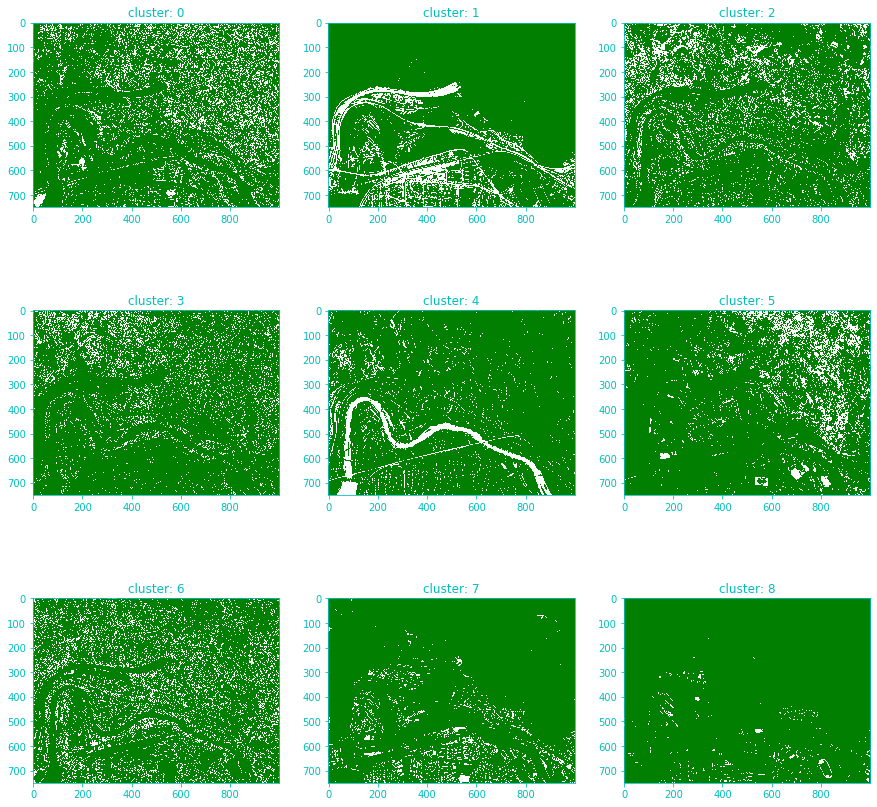

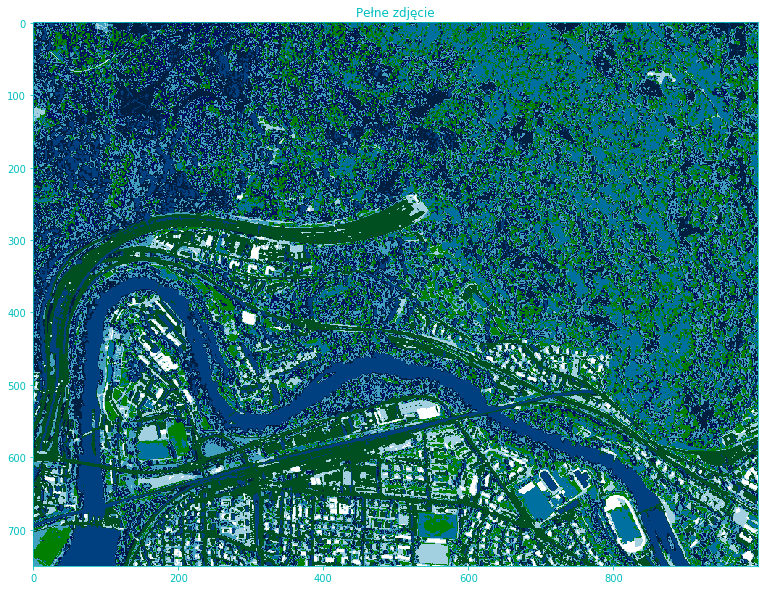

In [72]:

%%time
model = MiniBatchKMeans(n_clusters=9, n_init=10)
model.fit(X)
show_results(model)
print(f'Davies Bouldin index: {davies_bouldin_index(X, model.labels_, model.cluster_centers_)}')

In [11]:
%%time
birch = Birch(threshold=0.25, n_clusters=3)
birch.fit(X)
show_results(model)
#zastosowanie innych poznanych algorytmow powoduje przepełnienie pamięci

MemoryError: 

In [10]:
#%%time
#model = KMeans(n_clusters=3, n_init=10)
#model.fit(X)
#show_results(model)
#print(f'Davies Bouldin index: {davies_bouldin_index(X, model.labels_, model.cluster_centers_)}')

In [9]:
%%time
model = DBSCAN(eps=0.3, min_samples=10)
model.fit(X)

CPU times: user 7.84 s, sys: 54.8 ms, total: 7.89 s
Wall time: 7.89 s


DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

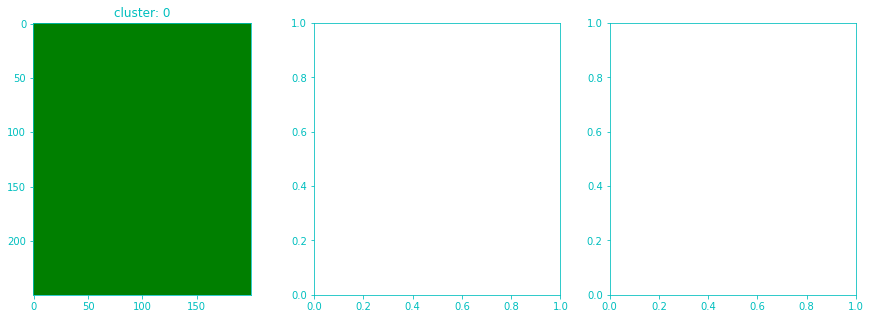

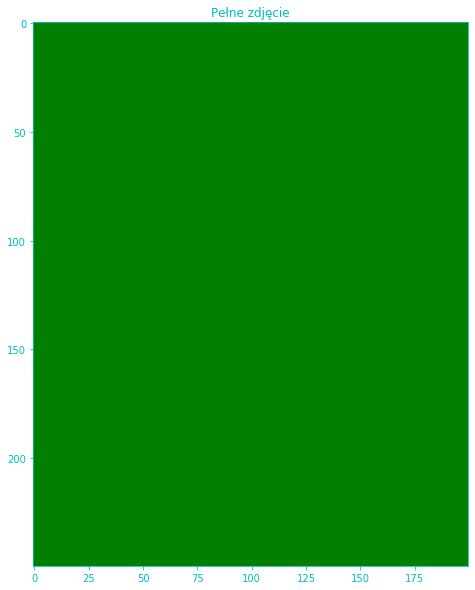

In [10]:
show_results(model)